In [1]:
import os
import shutil
import random
import pickle

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import chainer
from chainer.dataset import convert
import chainer.links as L
import chainer.functions as F
import chainer.initializers as I
from chainer import serializers

from tuner.dataset import ClassificationDataset, AugmentDataset
from tuner import net
from tuner import utils
from tuner.utils import maxmin_normalize
from tuner.load_data import arr2img 

/home/fytroo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


### ハイパーパラメータ

In [2]:
from easydict import EasyDict
args = EasyDict({
    'src_dir' : 'datasets/birds-dataset',
    'bs': 32, 
    'epoch' : 100,
    'lr' : 0.005,
    'gpu': 0,
    'out': 'result',
    'resume': '',
    'img_size': 128,
})
try:
    __file__.endswith('py')
    import argparse
    parser = argparse.ArgumentParser(description='Chainer example: MNIST')
    parser.add_argument('--batchsize', '-b', dest='bs', type=int, default=args.bs,
                        help='Number of images in each mini-batch')
    parser.add_argument('--epoch', '-e', type=int, default=args.epoch,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--learningrate', '-l', dest='lr', type=float, default=args.lr,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--frequency', '-f', type=int, default=-1,
                        help='Frequency of taking a snapshot')
    parser.add_argument('--gpu', '-g', type=int, default=args.gpu,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default=args.out,
                        help='Directory to output the result')
    parser.add_argument('--resume', '-r', default=args.resume,
                        help='Resume the training from snapshot')
    parser.add_argument('--unit', '-u', dest='n_in', type=int, default=args.n_in,
                        help='Number of units')
    parser.add_argument('--noplot', dest='plot', action='store_false',
                        help='Disable PlotReport extension')
    args = parser.parse_args()
except:
    print('no argsparse')
    pass

no argsparse


In [3]:
birds_dataset = ClassificationDataset(args.src_dir)

df = birds_dataset.df
df_finch = df[df['label'].str.contains('finch')]
df_finch['length'] = np.random.normal(25.5, 3, len(df_finch))
df_finch['weight'] = np.random.normal(85, 10, len(df_finch))

df_parrot = df[df['label'].str.contains('parrot')]
df_parrot['length'] = np.random.normal(55.5, 1, len(df_parrot))
df_parrot['weight'] = np.random.normal(850, 100, len(df_parrot))

df = pd.concat([df_finch, df_parrot])
df = df[['handle', 'length', 'weight']]

df.to_csv(os.path.join(args.src_dir, 'numeric_data.csv'), index=False)

/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

## ここまで画像に紐づく数値データを生成，ここからデータセット読み込み，学習をはじめる

### モデルを定義

In [4]:
class LeNet(chainer.Chain):
    def __init__(self, n_out=10):
        super(LeNet, self).__init__()
        
        initialW= I.HeNormal()
        with self.init_scope():
            self.conv0 = L.Convolution2D(None, 16, 1, 1, 0, initialW=initialW, nobias=True)
            
            self.bn11 = L.BatchNormalization(16)
            self.conv11 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn12 = L.BatchNormalization(32)
            self.conv12 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.bn21 = L.BatchNormalization(32)
            self.conv21 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn22 = L.BatchNormalization(64)
            self.conv22 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.conv_out = L.Convolution2D(None, n_out)
            self.fc = L.Linear(None, n_out)
    
    def __call__(self, x):
        h = x
        h = self.conv0(h)
        
        h = self.bn11(h)
        h = F.relu(h)
        h = self.conv11(h)
        h = self.bn12(h)
        h = F.relu(h)
        h = self.conv12(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        
        h = self.bn21(h)
        h = F.relu(h)
        h = self.conv21(h)
        h = self.bn22(h)
        h = F.relu(h)
        h = self.conv22(h)
        
        print('#1', h.shape)
        h = self.conv_out(h)
        print('#2', h.shape)
        h = F.squeeze(F.average_ppoling_2d(h,4))
        print('#3', h.shape)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        print('#4', h.shape)
        h = self.fc(h)
        
        return h

In [5]:
class LeNet(chainer.Chain):
    def __init__(self, n_out=10):
        super(LeNet, self).__init__()
        
        initialW= I.HeNormal()
        with self.init_scope():
            self.conv0 = L.Convolution2D(None, 16, 1, 1, 0, initialW=initialW, nobias=True)
            
            self.bn11 = L.BatchNormalization(16)
            self.conv11 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn12 = L.BatchNormalization(32)
            self.conv12 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.bn21 = L.BatchNormalization(32)
            self.conv21 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn22 = L.BatchNormalization(64)
            self.conv22 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.conv_out = L.Convolution2D(None, n_out)
            self.fc = L.Linear(None, 20)
            self.l1 = L.Linear(None, 20)
            self.l2 = L.Linear(None, n_out)
    
    def __call__(self, x, u):
        h = x
        h = self.conv0(h)
        
        h = self.bn11(h)
        h = F.relu(h)
        h = self.conv11(h)
        h = self.bn12(h)
        h = F.relu(h)
        h = self.conv12(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(h, ratio=0.4)
        
        h = self.bn21(h)
        h = F.relu(h)
        h = self.conv21(h)
        h = self.bn22(h)
        h = F.relu(h)
        h = self.conv22(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(h, ratio=0.5)
        
        h = self.fc(h)
        #h = F.relu(h)
        h = F.dropout(h, ratio=0.5)
        h = F.concat((h, u), axis=1)
        h = F.dropout(h, ratio=0.8)
        h = self.l1(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.6)
        h = self.l2(h)
        
        return h

In [6]:
birds_dataset = ClassificationDataset(args.src_dir)

### build model

In [7]:
n_label = birds_dataset.n_label 
model = L.Classifier(LeNet(n_label),
                    lossfun=F.softmax_cross_entropy,
                    accfun=F.accuracy)
xp = np
if args.gpu >= 0:
    import cupy as cp
    xp = cp
    chainer.cuda.get_device_from_id(args.gpu).use()
    model.to_gpu()  # Copy the model to the GPU
optimizer = chainer.optimizers.Adam(args.lr)
optimizer.setup(model)

### load dataset

In [8]:
df_num = pd.read_csv(os.path.join(args.src_dir, 'numeric_data.csv'))
df_train = pd.concat([birds_dataset.df_train, df_num,], axis=1, join='inner')
df_validation = pd.concat([birds_dataset.df_validation, df_num,], axis=1, join='inner')
u_train = df_train[['length','length']].values
u_val = df_validation[['length','length']].values

birds_dataset.load_data(resize=args.img_size, rescale=1)
x_train, y_train = birds_dataset.train_data
x_val, y_val = birds_dataset.validation_data

### data augmentation

In [9]:
import Augmentor
p = Augmentor.Pipeline()
p.crop_random(probability=1, percentage_area=0.8)
p.resize(probability=1, width=args.img_size, height=args.img_size)
p.flip_left_right(probability=0.5)
p.random_erasing(probability=0.5, rectangle_area=0.5)
p.shear(probability=0.3, max_shear_left=2, max_shear_right=2)

In [10]:
def unique_value_counts(df):
    for col in df.columns:
        c = df[col].value_counts().count()
        res[col] =c 
    return res

In [11]:
birds_dataset.counts_train_data()

{'red_finch': 183,
 'red_parrot': 128,
 'white_finch': 141,
 'white_parrot': 105,
 'yellow_finch': 169,
 'yellow_parrot': 113}

In [12]:
birds_dataset.counts_validation_data()

{'red_finch': 11,
 'red_parrot': 11,
 'white_finch': 11,
 'white_parrot': 11,
 'yellow_finch': 11,
 'yellow_parrot': 11}

### process data

In [13]:
def normalized_data(xs, us, ys):
    return (
        np.swapaxes(xs/255., 1, 3).astype(np.float32),
        maxmin_normalize(us).astype(np.float32),
        ys.astype(np.int8))

def dot_array(*args, xp=np):
    """convert to xp.array from each arg"""
    return tuple( xp.array(arg) for arg in args )

def dot_variable(*args):
    """convert to chainer.Variable from each arg"""
    return tuple( chainer.Variable(arg) for arg in args)

def chunk_array(array, batchsize=2):
    """get n-batch cyclicaly from Array(batchsize, data)"""
    index = idx = 0
    bs = batchsize
    while True:
        end = idx + bs
        yield np.take(array, range(idx, end) , axis=0, mode='wrap')
        idx = end

def get_batch(*arrays, batchsize=None):
    """apply each arg to cunck_array"""
    batchsize = batchsize if batchsize else len(arrays[0])
    gs = [ chunk_array(arr, batchsize) for arr in arrays]
    while True:
        yield tuple([ next(g) for g in gs])

def augment(xs, us, ys, p=None, batchsize=None):
    """execute data augmentaion"""
    batchsize = batchsize if batchsize else len(xs[0])
    g = p.keras_generator_from_array(xs.astype(np.uint8), ys.astype(np.uint8), batchsize)
    xs, ys = next(g)
    return (xs, us, ys)

def shuffled(*args):
    """shuffle list of arg with same order"""
    batch = list(zip(*args ))
    random.shuffle(batch)
    return zip(*batch)

In [14]:
x_train, u_train, y_train = shuffled(x_train, u_train, y_train)

bs = args.bs
g = get_batch(x_train, u_train, y_train, batchsize=bs)
g = (augment(*args, p=p, batchsize=bs) for args in g)
g = (normalized_data(xs, us, ys) for (xs, us, ys) in g)
g = (dot_array(*args, xp=cp) for args in g)
g = (dot_variable(*args) for args in g)
g_train = g

In [15]:
g = get_batch(x_val, u_val, y_val)
g = (normalized_data(xs, us, ys) for (xs, us, ys) in g)
g = (dot_array(*args, xp=cp) for args in g)
g = (dot_variable(*args) for args in g)
g_val = g

variable([0 2 3 1 2 4 3 1 4 5 4 0 2 1 1 0 4 4 5 5 0 5 3 1 1 1 3 1 0 0 0 4])


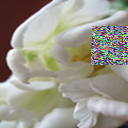

In [16]:
xs, us, ys = next(g_train)
print(ys)
a = xs[2].data
a = cp.asnumpy(a)
a = np.swapaxes(a*255., 0, 2).astype(np.uint8)
arr2img(a)

variable([0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
          4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3])


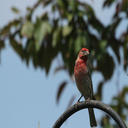

In [17]:
xs, us, ys = next(g_val)
print(ys)
a = xs[2].data
a = cp.asnumpy(a)
a = np.swapaxes(a*255., 0, 2).astype(np.uint8)
arr2img(a)

### 訓練と検証

In [18]:
def train(step=None, step_per_print=100):
    x, u, t = next(g_train) 
    optimizer.update(model, x, u, t)
    with chainer.using_config('train', True):
        loss = model(x,u,t)

    loss = float(loss.data)
    acc = float(model.accuracy.data)

    if step%step_per_print==0:
        print('step:{}'.format(step))
        print('loss: {:.4f}\t acc: {:.4f}'.format(loss, acc))

def validation(step=None):
    x, u, t = next(g_val) 
    with chainer.using_config('train', False):
        loss = model(x, u, t)

    loss = float(loss.data)
    acc = float(model.accuracy.data)

    print('val_loss: {:.4f}\t val_acc: {:.4f}'.format(loss, acc))

#for step in range(args.epoch):
for step in range(int(1e4)):
    train(step)
    if step%1000==0:
        validation(step)

step:0
loss: 62.7172	 acc: 0.1562
val_loss: 659.3680	 val_acc: 0.1667
step:100
loss: 6.5123	 acc: 0.1562
step:200
loss: 2.0245	 acc: 0.2188
step:300
loss: 1.8096	 acc: 0.2500
step:400
loss: 2.1339	 acc: 0.3125
step:500
loss: 1.5954	 acc: 0.3750
step:600
loss: 1.6494	 acc: 0.5000
step:700
loss: 1.9260	 acc: 0.1250
step:800
loss: 1.6111	 acc: 0.0938
step:900
loss: 1.5639	 acc: 0.3438
step:1000
loss: 1.6986	 acc: 0.1562
val_loss: 1.7585	 val_acc: 0.1818


KeyboardInterrupt: 

In [19]:
from datetime import datetime

In [20]:
model.to_cpu()

serializers.save_hdf5(f'models/birds_online.20180126.hdf5', model)

with open('models/birds_online.20180126.model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [21]:
with open('models/birds_online.20180126.model.pkl', 'rb') as f:
    m = pickle.load(f)

### 0,3 -> red finch 

In [28]:
xs, us, ys = normalized_data(x_val, u_val, y_val)
out = F.softmax(m.predictor(xs, us))

In [23]:
xs.shape, us.shape, ys.shape

((66, 3, 128, 128), (66, 2), (66,))

In [25]:
xs.dtype, us.dtype, ys.dtype

(dtype('float32'), dtype('float32'), dtype('int8'))

In [42]:
def get_bar(arr):
    plt.style.use('ggplot')
    plt.bar(np.arange(arr.size), arr)
    plt.show()

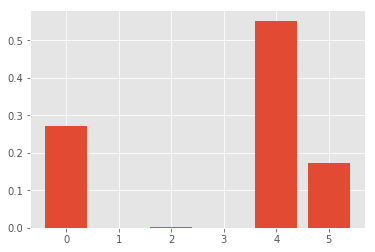

In [44]:
get_bar(out[6].data)

In [49]:
from tuner import load_data
df = load_data.df_fromdir_classed('standard_datasets/5a606243b037cb270b56c29c/validation/')

df_num = pd.read_csv(os.path.join('datasets/birds-dataset', 'numeric_data.csv'))

df = pd.concat([df, df_num,], axis=1, join='inner')


def normalized_data(xs, us, ys):
    return (
        np.swapaxes(xs/255., 1, 3).astype(np.float32),
        utils.maxmin_normalize(us).astype(np.float32),
        ys.astype(np.int8))

tx_val, ty_val = load_data.load_fromdf(df)
tu_val = df[['length','weight']].values

xs, us, ys = normalized_data(tx_val, tu_val, ty_val)
xs.shape, us.shape, ys.shape, xs.dtype, us.dtype, ys.dtype

((66, 3, 28, 28),
 (66, 2),
 (66,),
 dtype('float32'),
 dtype('float32'),
 dtype('int8'))

In [50]:
xs, us, ys = normalized_data(x_val, u_val, y_val)
xs.shape, us.shape, ys.shape, xs.dtype, us.dtype, ys.dtype

((66, 3, 128, 128),
 (66, 2),
 (66,),
 dtype('float32'),
 dtype('float32'),
 dtype('int8'))

In [51]:
out.data.shape

(66, 6)

In [52]:
birds_dataset.labels

['red_finch',
 'red_parrot',
 'white_finch',
 'white_parrot',
 'yellow_finch',
 'yellow_parrot']

In [37]:
df_out = pd.DataFrame(out.data, columns=birds_dataset.labels)

<IPython.core.display.Javascript object>


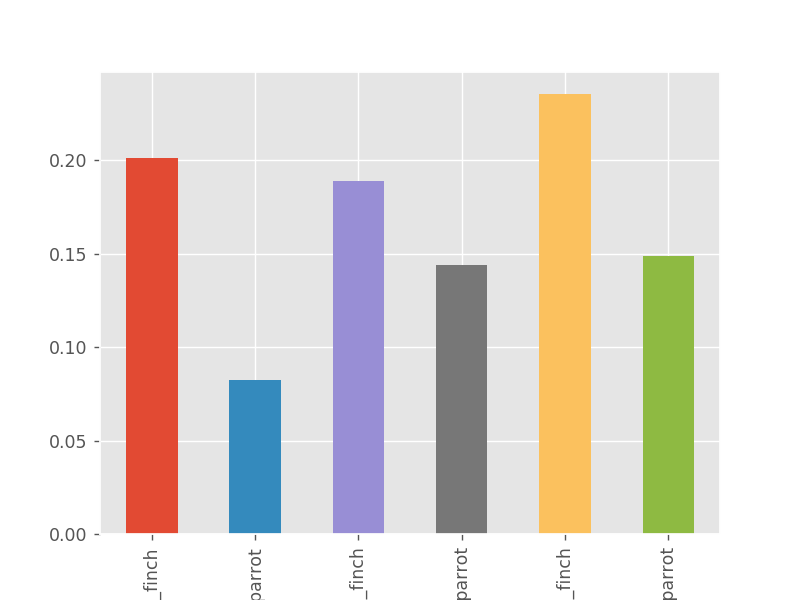

In [45]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df_out.ix[0].plot.bar()